In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint,uniform
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import InputLayer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from  scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
import keras_tuner as kt

In [13]:
def load_data():
    train_data = pd.read_csv('train.csv')
    return train_data
train_data = load_data()
target_data = train_data["Personality"].copy()
training_data = train_data.drop(columns=["Personality","id"]).copy()

training_data['Socializing_effect'] = training_data['Social_event_attendance'] + training_data['Going_outside'] 
training_data['probability_of_having_friends'] = training_data['Socializing_effect'] / (training_data['Socializing_effect'].max() + 1e-5)
training_data['prob_of_going_outside'] = training_data['Going_outside'] / (training_data['Going_outside'].max() + 1e-5)
training_data['online_presence'] = training_data['Post_frequency'] * training_data['Friends_circle_size']

num_attributes = training_data.select_dtypes(include=[np.number]).columns.tolist()
cat_attributes = training_data.select_dtypes(exclude=[np.number]).columns.tolist()


corr_matrix = training_data.select_dtypes(include=[np.number]).corr()
training_data.head()
train_data.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [14]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean',missing_values=np.nan)),
    ('scaler', StandardScaler()),])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('one_hot_encoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

pre_processor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_attributes),
    ('cat', cat_pipeline, cat_attributes),
])

le = LabelEncoder()
y_processed = le.fit_transform(target_data)


In [15]:
def compute_class_weights(train_data):
    class_weight = compute_class_weight(class_weight='balanced',classes = np.unique(train_data["Personality"]),y=train_data["Personality"])
    class_weight_dict = dict(enumerate(class_weight))
    print("Class weights computed")
    return class_weight_dict

class_weights = compute_class_weights(train_data)

Class weights computed


In [16]:
rf_clf = RandomForestClassifier(n_estimators=152, max_depth=13,
                                min_samples_split=3, min_samples_leaf=9,
                                max_features='log2', bootstrap=False,ccp_alpha=0.09488855372533334,
                                class_weight=class_weights, random_state=42,warm_start=False)

model_pipeline = Pipeline([
    ('preprocessor', pre_processor),
    ('classifier', rf_clf)
])

cv_scores = cross_validate(model_pipeline,training_data,y_processed, cv=5, scoring=['accuracy','precision'])
cv_scores = pd.DataFrame(cv_scores)
print("Cross-validation scores for Random Forest Classifier:",cv_scores.mean())

Cross-validation scores for Random Forest Classifier: fit_time          1.034295
score_time        0.012480
test_accuracy     0.968582
test_precision    0.942741
dtype: float64


In [17]:
param_dict = {
    'classifier__n_estimators': randint(100,500),
    'classifier__max_depth': randint(0,20),
    'classifier__min_samples_split': randint(2,10),
    'classifier__min_samples_leaf': randint(0,10),
    'classifier__max_features': ['sqrt', 'log2', 0.3],
    'classifier__ccp_alpha': uniform(0,0.1),
    'classifier__bootstrap': [True, False],
    'classifier__warm_start': [True, False]
}

random_search = RandomizedSearchCV(estimator=model_pipeline, param_distributions=param_dict, n_iter=10,
                                   scoring='accuracy', cv=10, verbose=1, random_state=42, n_jobs=-1,
                                   error_score='raise')
random_search.fit(training_data, y_processed)
print(random_search.best_params_, random_search.best_score_)
print("random_search completed.")

Fitting 10 folds for each of 10 candidates, totalling 100 fits


InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 0 instead.

[[0.90438823 0.09561177]
 [0.90438823 0.09561177]
 [0.05167421 0.94832579]
 ...
 [0.03885082 0.96114918]
 [0.25831471 0.74168529]
 [0.90616382 0.09383618]]


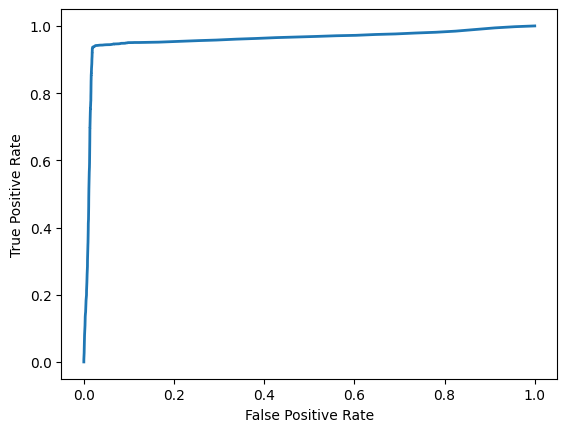

Model training and evaluation completed.


In [ ]:
prd_scores = cross_val_predict(model_pipeline, training_data ,y_processed, cv=20, method='predict_proba')
print(prd_scores)
fpr, tpr, thresholds = roc_curve(y_processed, prd_scores[:, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label, linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
plot_roc_curve(fpr, tpr, label='ROC Curve')
print("Model training and evaluation completed.")

In [ ]:
rf_clf.fit(X_processed, y_processed)

test_data = pd.read_csv('test.csv')

test_data['Socializing_effect'] = test_data['Social_event_attendance'] + test_data['Going_outside'] 
test_data['probability_of_having_friends'] = test_data['Socializing_effect'] / (test_data['Socializing_effect'].max() + 1e-5)
test_data['prob_of_going_outside'] = test_data['Going_outside'] / (test_data['Going_outside'].max() + 1e-5)
test_data['online_presence'] = test_data['Post_frequency'] * test_data['Friends_circle_size']

test_data_processed = pre_processor.transform(test_data)
rf_predictions = rf_clf.predict(test_data_processed)
sub_data = pd.DataFrame({'id': test_data['id'], 'Personality': rf_predictions})
sub_data['Personality'] = le.inverse_transform(sub_data['Personality'])
sub_data.to_csv('submission.csv', index=False)
print("Submission file created.")

Submission file created.
